In [1]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../../azimuth.env")

# Add PATH_ROOT to Python path
import sys
sys.path.append(os.getenv("PATH_ROOT"))

print(f'PATH_ROOT: {os.getenv("PATH_ROOT")}')

PATH_ROOT: /Users/thinhhoang/Documents/project-azimuth/


# Thomas-Jensen Problem Generation

We use the Thomas-Jensen Process to generate the transit process of aircraft through an airspace (without turns).

In [4]:
# Testing Thomas-Jensen Transit Process

import MARTINI.airspace.randomize_airspace as randomize_airspace
import MARTINI.arrivals.thomas as thomas
import MARTINI.airspace.geo as geo
import MARTINI.airspace.intersect as intersect

# Generate a polygon
polygon, area = randomize_airspace.generate_unit_polygon(5, 500, seed=69420)

entry_points, exit_points, velocity_vectors = thomas.generate_problem_thomas_jensen(polygon, lambda_parent=8e-3, mu=2, sigma=12, min_dist_to_vertex=42, min_transit_length=96)
print(f'There are {len(entry_points)} entries generated')
print(f'There are {len(exit_points)} exits generated')
print(f'There are {len(velocity_vectors)} velocity vectors generated')


There are 26 entries generated
There are 26 exits generated
There are 26 velocity vectors generated


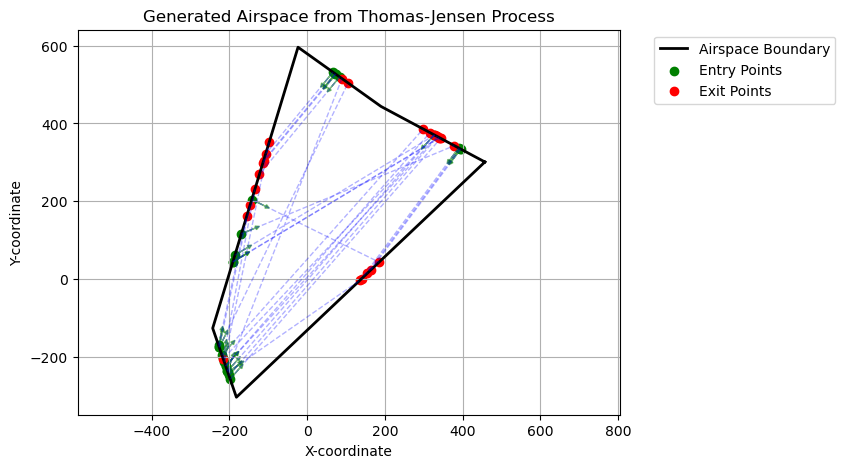

In [5]:
thomas.visualize_airspace(polygon, entry_points, exit_points, velocity_vectors)

# TRAJCLUS-HDBSCAN (TRC) for Flow Structuring

In [8]:
import numpy as np
import matplotlib.pyplot as plt


In [9]:
trajectories = [[x, y] for x, y in zip(entry_points, exit_points)]
trajectories = np.array(trajectories)

print(f'There are {len(trajectories)} trajectories generated')

There are 26 trajectories generated


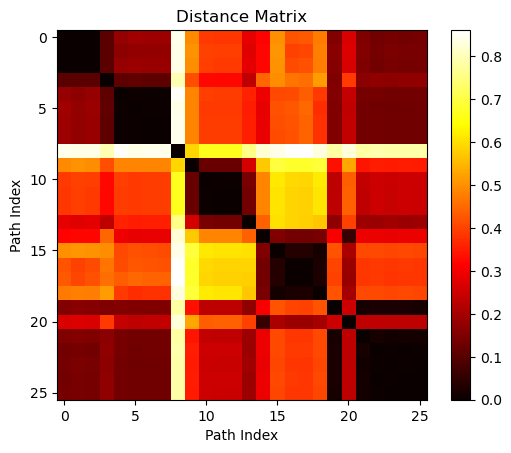

In [18]:
# Compute the distance matrix
from ALPHA.dirichlet.trajclus_features import compute_distance_matrix
from ALPHA.dirichlet.hdbs import perform_clustering

distance_matrix = compute_distance_matrix(trajectories)
# Visualize the distance matrix
plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Distance Matrix')
plt.xlabel('Path Index')
plt.ylabel('Path Index')
plt.show()



In [19]:
# Perform clustering
cluster_labels, clusterer = perform_clustering(trajectories)

print(f'There are {len(np.unique(cluster_labels))} clusters')


There are 3 clusters


In [23]:
polygon

array([[ 456.9914332 ,  300.82983858],
       [ 189.94131248,  443.60617662],
       [ -23.49674707,  595.91748172],
       [-242.94845818, -126.75289102],
       [-181.97161491, -304.18903186]])

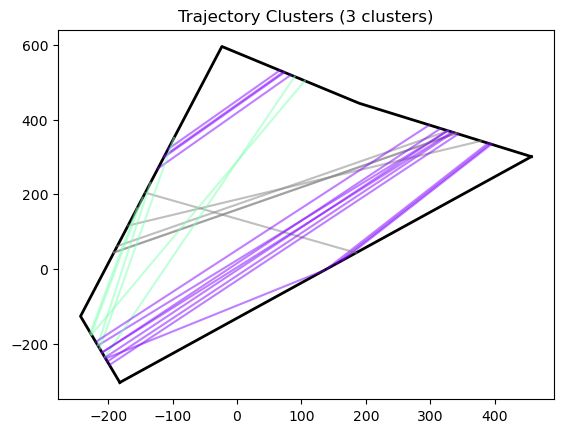

In [25]:
# Plot the airspace boundary
plt.plot(polygon[:, 0], polygon[:, 1], 'k-', linewidth=2, label='Airspace Boundary')
plt.plot([polygon[-1, 0], polygon[0, 0]], [polygon[-1, 1], polygon[0, 1]], 'k-', linewidth=2)



# Plot the clusters
unique_labels = np.unique(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for i in range(trajectories.shape[0]):
    color = colors[cluster_labels[i]] if cluster_labels[i] >= 0 else 'gray'
    plt.plot(trajectories[i, :, 0], trajectories[i, :, 1], c=color, alpha=0.5)

plt.title(f'Trajectory Clusters ({len(unique_labels)} clusters)')
plt.show()
